## 数学建模算法：K-Means 聚类算法

### 概念

聚类属于无监督学习，指在没有参照系下对样本集合进行分组，这种分组往往是无标签化的，即分类后无法知道这一类的意义，仅仅是在特征上具有较大相似性。K-means算法是常见的聚类算法，在给定分类组数的情况下算法自动进行分类。

K-means算法支持大于2维的特性维度，但不支持过大维度的特性。同时对噪声点较为敏感，需要进行一定的数据处理。在聚类上，关键依据是样本的特征向量在空间中互相的距离。

### 几何距离

距离即为两个样本的间隔，定义样本的特征为：
$$
X = [x_1, x_2, \dots, x_d]^T, d \ refers\  to\  the\  Dimension
$$

常见距离算法如下：
（可参考知乎文章：https://zhuanlan.zhihu.com/p/374627115）


1. 明氏距离：
    $$
    pdist(x, 'minkowski', r) = [\sum_{k=1}^d{|x_i_k - x_j_k|^m}]^{\frac{1}{m}}
    $$
+ 当m=1时为曼哈顿距离
    当数据集具有离散和/或二进制属性时，Manhattan似乎工作得很好，因为它考虑了在这些属性的值中实际可以采用的路径。以欧几里得距离为例，它会在两个向量之间形成一条直线，但实际上这是不可能的。
+ 当m=2时为欧几里得距离 
    尽管欧几里德距离是一种常见的距离度量，但它不是尺度不变的，这意味着计算的距离可能是倾斜的，这取决于特征的单位。通常，在使用这个距离度量之前，需要对数据进行标准化（normalize）。

2. 切氏距离:
    $$
    max(abs(x_i-x_j)) = {max}\limits_{1\leq k \leq d} |x_i_k-x_j_k|
    $$
3. 马氏距离：
    马氏距离是欧几里得距离维度，权重归一化后的集合距离，即经过了标准化处理，较为常用：
    $$
    pdist(x, 'mahal') = [(x_i-x_j)^T \sum^{-1}(x_i-x_j)]^{\frac{1}{2}}
    $$
   
### 算法实现

K-means 有一个著名的解释：牧师—村民模型：

> 有四个牧师去郊区布道，一开始牧师们随意选了几个布道点，并且把这几个布道点的情况公告给了郊区所有的村民，于是每个村民到离自己家最近的布道点去听课。听课之后，大家觉得距离太远了，于是每个牧师统计了一下自己的课上所有的村民的地址，搬到了所有地址的中心地带，并且在海报上更新了自己的布道点的位置。牧师每一次移动不可能离所有人都更近，有的人发现A牧师移动以后自己还不如去B牧师处听课更近，于是每个村民又去了离自己最近的布道点。就这样，牧师每个礼拜更新自己的位置，村民根据自己的情况选择布道点，最终稳定了下来。我们可以看到该牧师的目的是为了让每个村民到其最近中心点的距离和最小。

从上述故事不难发现K-means分为两步：
1. 统计k个组的中心对象，并重新按k个中心对象确立k个组
2. 以中心对象为准则，每个点与k个中心分别计算距离并归近最近中心点的组
直到中心对象不再移动，分类完毕。而整个过程的初始是随机给k个点。
（虽然这里我们说随机初始值，但是如果初始点与期望分组中心越接近，结果越准确）


#### 鸢尾花聚类

鸢尾花数据集是机器学习中相当经典的例子，里面仅仅150个样本，每个样本有4列特征。我们仅仅使用petalWidth, petalLength两组特征数据：

In [6]:
from sklearn.datasets import load_iris     #从sklearn库中导入鸢尾花数据集
iris = load_iris()
Y = iris.target
data = []
petalLength = []
petalWidth = []
for i in iris.data:
    data.append([i[2],i[3]])
    petalLength.append(i[2])
    petalWidth.append(i[3])
    
print(data[:5]) # 打印前5个数据

[[1.4, 0.2], [1.4, 0.2], [1.3, 0.2], [1.5, 0.2], [1.4, 0.2]]


在K-means算法前，还需要定义两个函数，计算距离与计算组的中心对象，这里我们使用欧式距离：

In [22]:
import numpy as np
import math, random
import matplotlib.pyplot as plt

def eucliDist(A, B):
    # 多维欧拉距离
    return float('{:.10f}'.format(math.sqrt(sum([(a - b)**2 for (a,b) in zip(A,B)]))))


def centerPoint(point_set):
    # 获取点的维度
    dim = len(point_set[0])
    res = []
    for i in range(dim):
        res.append(0)
    for i in range(dim):
        for j in point_set:
            res[i] += j[i]
    for i in range(dim):
        res[i] = res[i] / len(point_set) # 每个维度依次求平均，重心求法
    return res

进入K-means算法部分，按照原理模拟即可：

In [34]:
def myKMeans(n_clusters):
    key_index = random.sample(range(1, len(data)), n_clusters)
    # key_index = [20, 80, 140]
    # 这里并没有选择随机，而是选择了三个直观符合分类分布的三个点为初始值
    is_change = True
    key_point = []
    group = [[] for _ in range(n_clusters)]
    cmp = 0
    # 初始化：以n个关键点分组
    for i in range(n_clusters):
        group[i].append(data[key_index[i]])
        # i同时对应group与key
        key_point.append(data[key_index[i]])
        
    # 迭代器
    while is_change:
        # 遍历所有点
        for i in range(len(data)):
            # 与n个目标点比较
            tmp_dis = []
            for j in range(n_clusters):
                tmp_dis.append(eucliDist(key_point[j], data[i]))
            min_index = np.argmin(np.array(tmp_dis))
            group[min_index].append(data[i])

        # 计算每组的中心对象
        tmp_key_point = []
        for i in range(n_clusters):
            new_center = centerPoint(group[i])
            tmp_key_point.append(new_center)
            cmp += float(eucliDist(new_center, key_point[i]))
        # 比较中心点与目标点差异
        if cmp < 0.00002:
            is_change = False
            key_point = tmp_key_point
        else:
            is_change = True
            key_point = tmp_key_point
            cmp = 0
            for i in range(n_clusters):
                group[i][0] = key_point[i]
    predicted = []
    for d in data:
        for j in range(n_clusters):
            if d in group[j]:
                predicted.append(j)
                break
    return predicted, group, key_point

接收结果并且数据可视化结果：

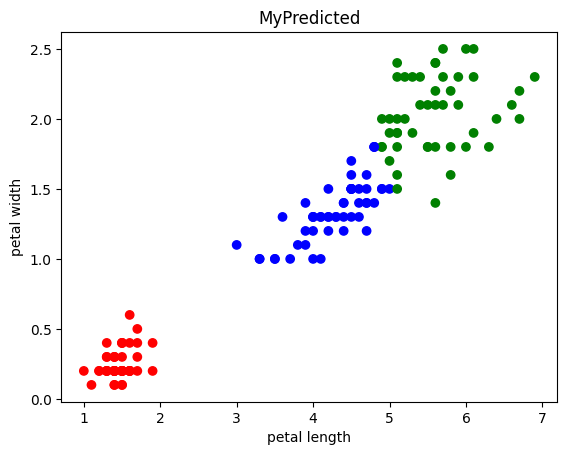

In [12]:
n = 3
p, g, k = myKMeans(n)
colors_p = []
for i in p:
    if i == 0:
        colors_p.append("red")
    elif i == 1:
        colors_p.append("blue")
    else:
        colors_p.append("green")

plt.title("MyPredicted")
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.scatter(petalLength, petalWidth, c=colors_p)
plt.show()

### 选择K值

在上述例子中，由于我们已知鸢尾花的分类共有3个，所以定义K为3，但是现实中可能我们无法判断出K的取值，这时候我们可以使用手肘法去判断K的合理数值：

1. 定义聚类的误差平方和：
    $$
    SSE = \sum\limits_{i=1}^{k} \sum\limits_{x\in{c_i}} ||x-\mu_i||^2
    $$

In [35]:
def square_error(centers, d, p):
    cnt = 0
    for i in range(len(d)):
        c = p[i]
        cnt += (eucliDist(centers[c], d[i]) ** 2)
    return cnt

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
150


2. 返回不同K下的取值:寻找图中的曲折点即可

In [37]:
sse = []
for i in range(2,10):
    p,g,k = myKMeans(i)
    sse.append(square_error(k, data, p))
    
print(sse)

[86.39021984427383, 31.376690842832055, 30.7879545602964, 48.880068799307956, 31.622228759240915, 15.540982608764894, 76.7106943462022, 9.225757993124816]


可视化SSE列表：

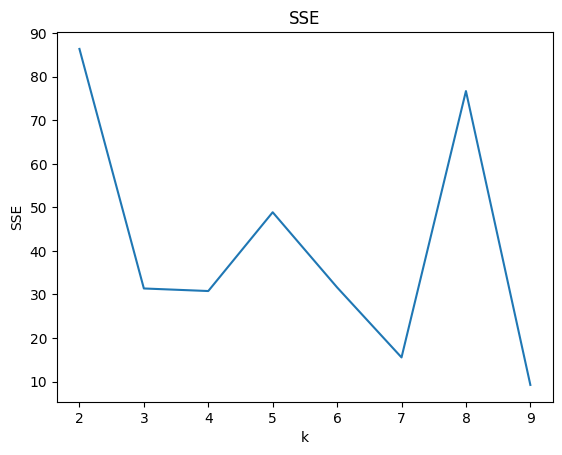

In [38]:
plt.title("SSE")
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot([2,3,4,5,6,7,8,9],sse)

plt.show()